<a id="section-0"></a>
# Introduction

This Project consists of multiple parts and is focussed on the power market.

In a first step, general intutions on how power prices are formed on the spot market will be discussed.

Secondly, German power market as well as weather data will be imported and manipulated for the later usage.

Thirdly, a regression model will be run to gain insights in the effect of the weather data as well as the time of the day on power prices.

Lastly, an economic model will be built and executed which takes the perspective of an exporter who owns a hydropower plant outside of Germany and wishes to maximize it's revenue of exporting hydropower to the country.

Table of Contents
-----------------
- [Introduction](#section-0)
- [Power Market Fundamentals](#section-1)
  - [The Merit Order Curve](#subsection-12)
- [Data Imports](#section-2)
  - [Weather Data Import](#subsection-21)
  - [Price Data Import](#subsection-22)
- [Combining the Datasets](#section-3)
  - [The Merge](#subsection-31)
  - [Additional Data Manipulation](#subsection-32)
- [Regression Analysis](#section-4)
  - [Mathematical Description of the Model](#subsection-41)
  - [Execution of the Regression Analysis](#subsection-42)
- [The Economic Model](#section-5)
  - [Description of the Model](#subsection-51)
  - [Solving the Model](#subsection-52)
  - [Graphical Inspection of the Solution](#subsection-53)

# Imports

In [107]:

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

import openmeteo_requests
import statsmodels.api as sm
import requests_cache
import pandas as pd
from retry_requests import retry

<a id="section-1"></a>
# Power Market Fundamentals

I didn't have time to finish this part. It is also not essential to the project but I wanted to play around with it. If you're interested, a quick google search about the merit order curve should suffice to understand how power prices are set.

<a id="subsection-12"></a>
## The Merit Order Curve

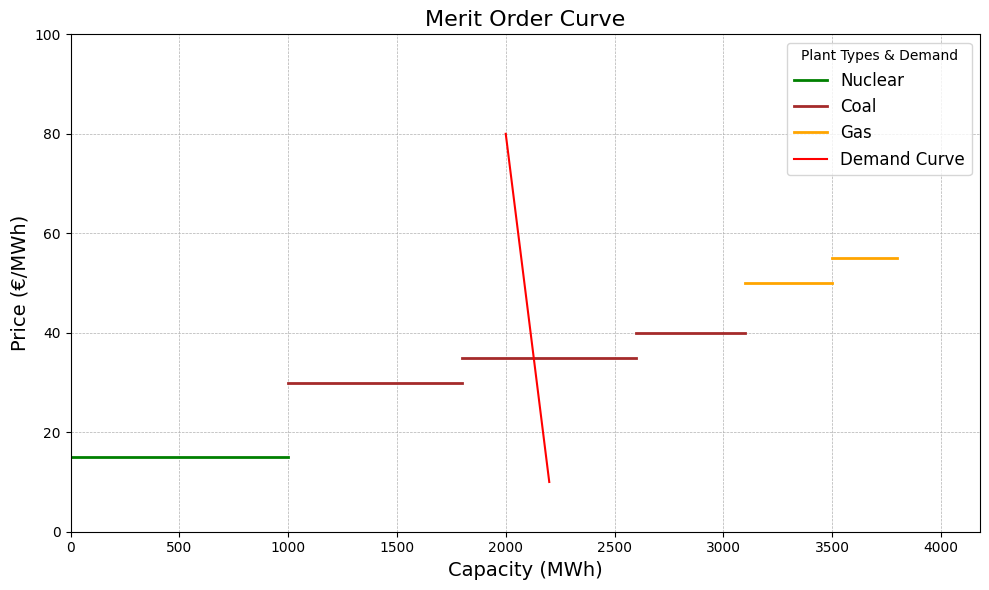

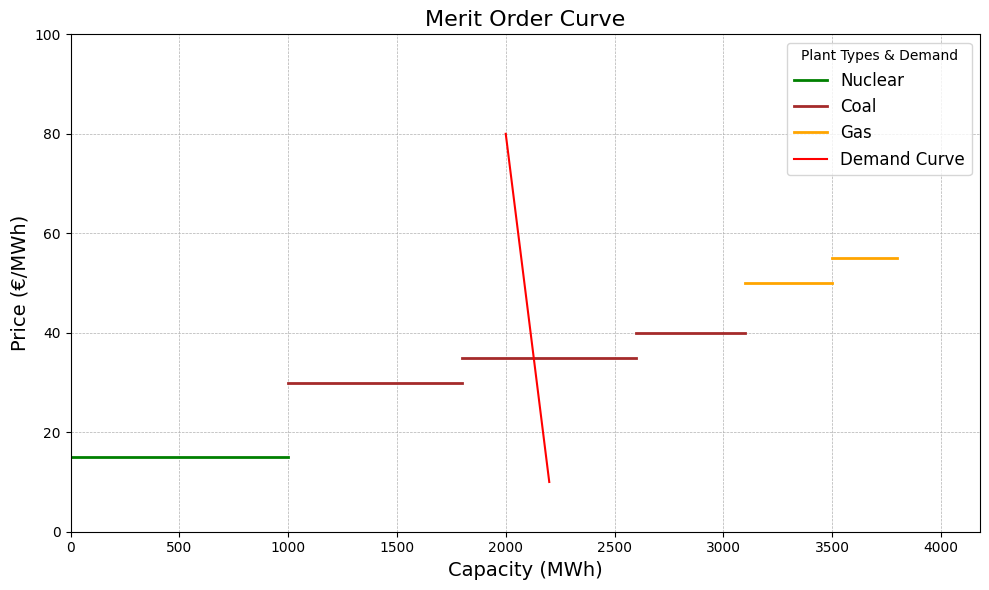

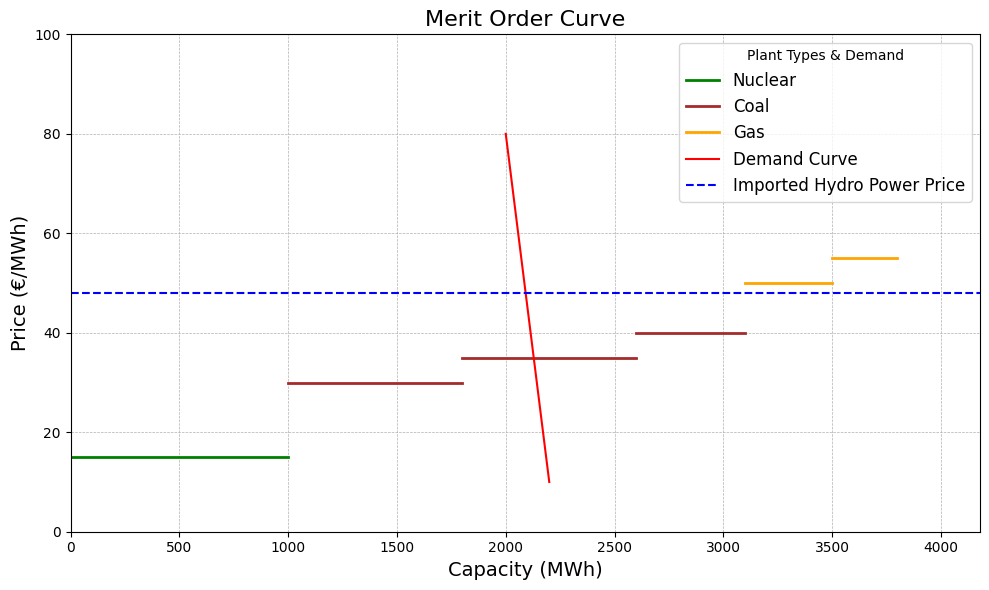

In [32]:
plants = [
    {'name': 'Nuclear', 'capacity': 1000, 'cost': 15, 'type': 'Nuclear'},
    {'name': 'Coal1', 'capacity': 800, 'cost': 30, 'type': 'Coal'},
    {'name': 'Coal2', 'capacity': 800, 'cost': 35, 'type': 'Coal'},
    {'name': 'Coal3', 'capacity': 500, 'cost': 40, 'type': 'Coal'},
    {'name': 'Gas1', 'capacity': 400, 'cost': 50, 'type': 'Gas'},
    {'name': 'Gas2', 'capacity': 300, 'cost': 55, 'type': 'Gas'}
]

sorted_plants = sorted(plants, key=lambda x: x['cost'])

colors = {'Nuclear': 'green', 'Coal': 'brown', 'Gas': 'orange'}

cum_capacities = np.cumsum([plant['capacity'] for plant in sorted_plants])
labels = [plant['name'] for plant in sorted_plants]

def plot_merit_order(demand, residual_load, hydro_price=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    start_capacity = 0
    plot_labels_done = []

    for plant in sorted_plants:
        end_capacity = start_capacity + plant['capacity']
        ax.plot([start_capacity, end_capacity], [plant['cost'], plant['cost']],
                linewidth=2, color=colors[plant['type']], 
                label=plant['type'] if plant['type'] not in plot_labels_done else "")
        plot_labels_done.append(plant['type'])
        start_capacity = end_capacity
    
    ax.plot([2000, 2200], [80, 10], 'r-', label='Demand Curve')

    if hydro_price:
        ax.axhline(y=hydro_price, color='blue', linestyle='--', label='Imported Hydro Power Price')

    ax.set_xlim(0, max(cum_capacities) * 1.1)
    ax.set_ylim(0, 100)
    
    ax.set_xlabel('Capacity (MWh)', fontsize=14)
    ax.set_ylabel('Price (€/MWh)', fontsize=14)
    ax.set_title('Merit Order Curve', fontsize=16)
    ax.legend(title="Plant Types & Demand", loc='upper right', fontsize=12)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_merit_order(demand=3000, residual_load=1500)  # High renewables generation scenario
plot_merit_order(demand=3000, residual_load=500)   # Lower renewables generation scenario
plot_merit_order(demand=3000, residual_load=500, hydro_price=48)  # Hydro power import scenario

<a id="section-2"></a>
# Data Imports

<a id="subsection-21"></a>
## Weather Data Import

In [33]:

# I download weather data with the Open-Meteo API client
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 53.5507,
	"longitude": 9.993,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"hourly": ["wind_speed_100m", "shortwave_radiation"]
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

hourly = response.Hourly()
hourly_wind_speed_100m = hourly.Variables(0).ValuesAsNumpy()
hourly_shortwave_radiation_instant = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation_instant

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 53.53251266479492°N 9.980878829956055°E
Elevation 11.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  wind_speed_100m  shortwave_radiation
0    2023-01-01 00:00:00+00:00        50.550205                  0.0
1    2023-01-01 01:00:00+00:00        51.624554                  0.0
2    2023-01-01 02:00:00+00:00        52.915100                  0.0
3    2023-01-01 03:00:00+00:00        51.348927                  0.0
4    2023-01-01 04:00:00+00:00        49.430241                  0.0
...                        ...              ...                  ...
8755 2023-12-31 19:00:00+00:00        30.018473                  0.0
8756 2023-12-31 20:00:00+00:00        31.079071                  0.0
8757 2023-12-31 21:00:00+00:00        32.487881                  0.0
8758 2023-12-31 22:00:00+00:00        33.927967                  0.0
8759 2023-12-31 23:00:00+00:00        32.696640                  0.0

[8760 rows x 3 columns]


### Graphical Inspection 

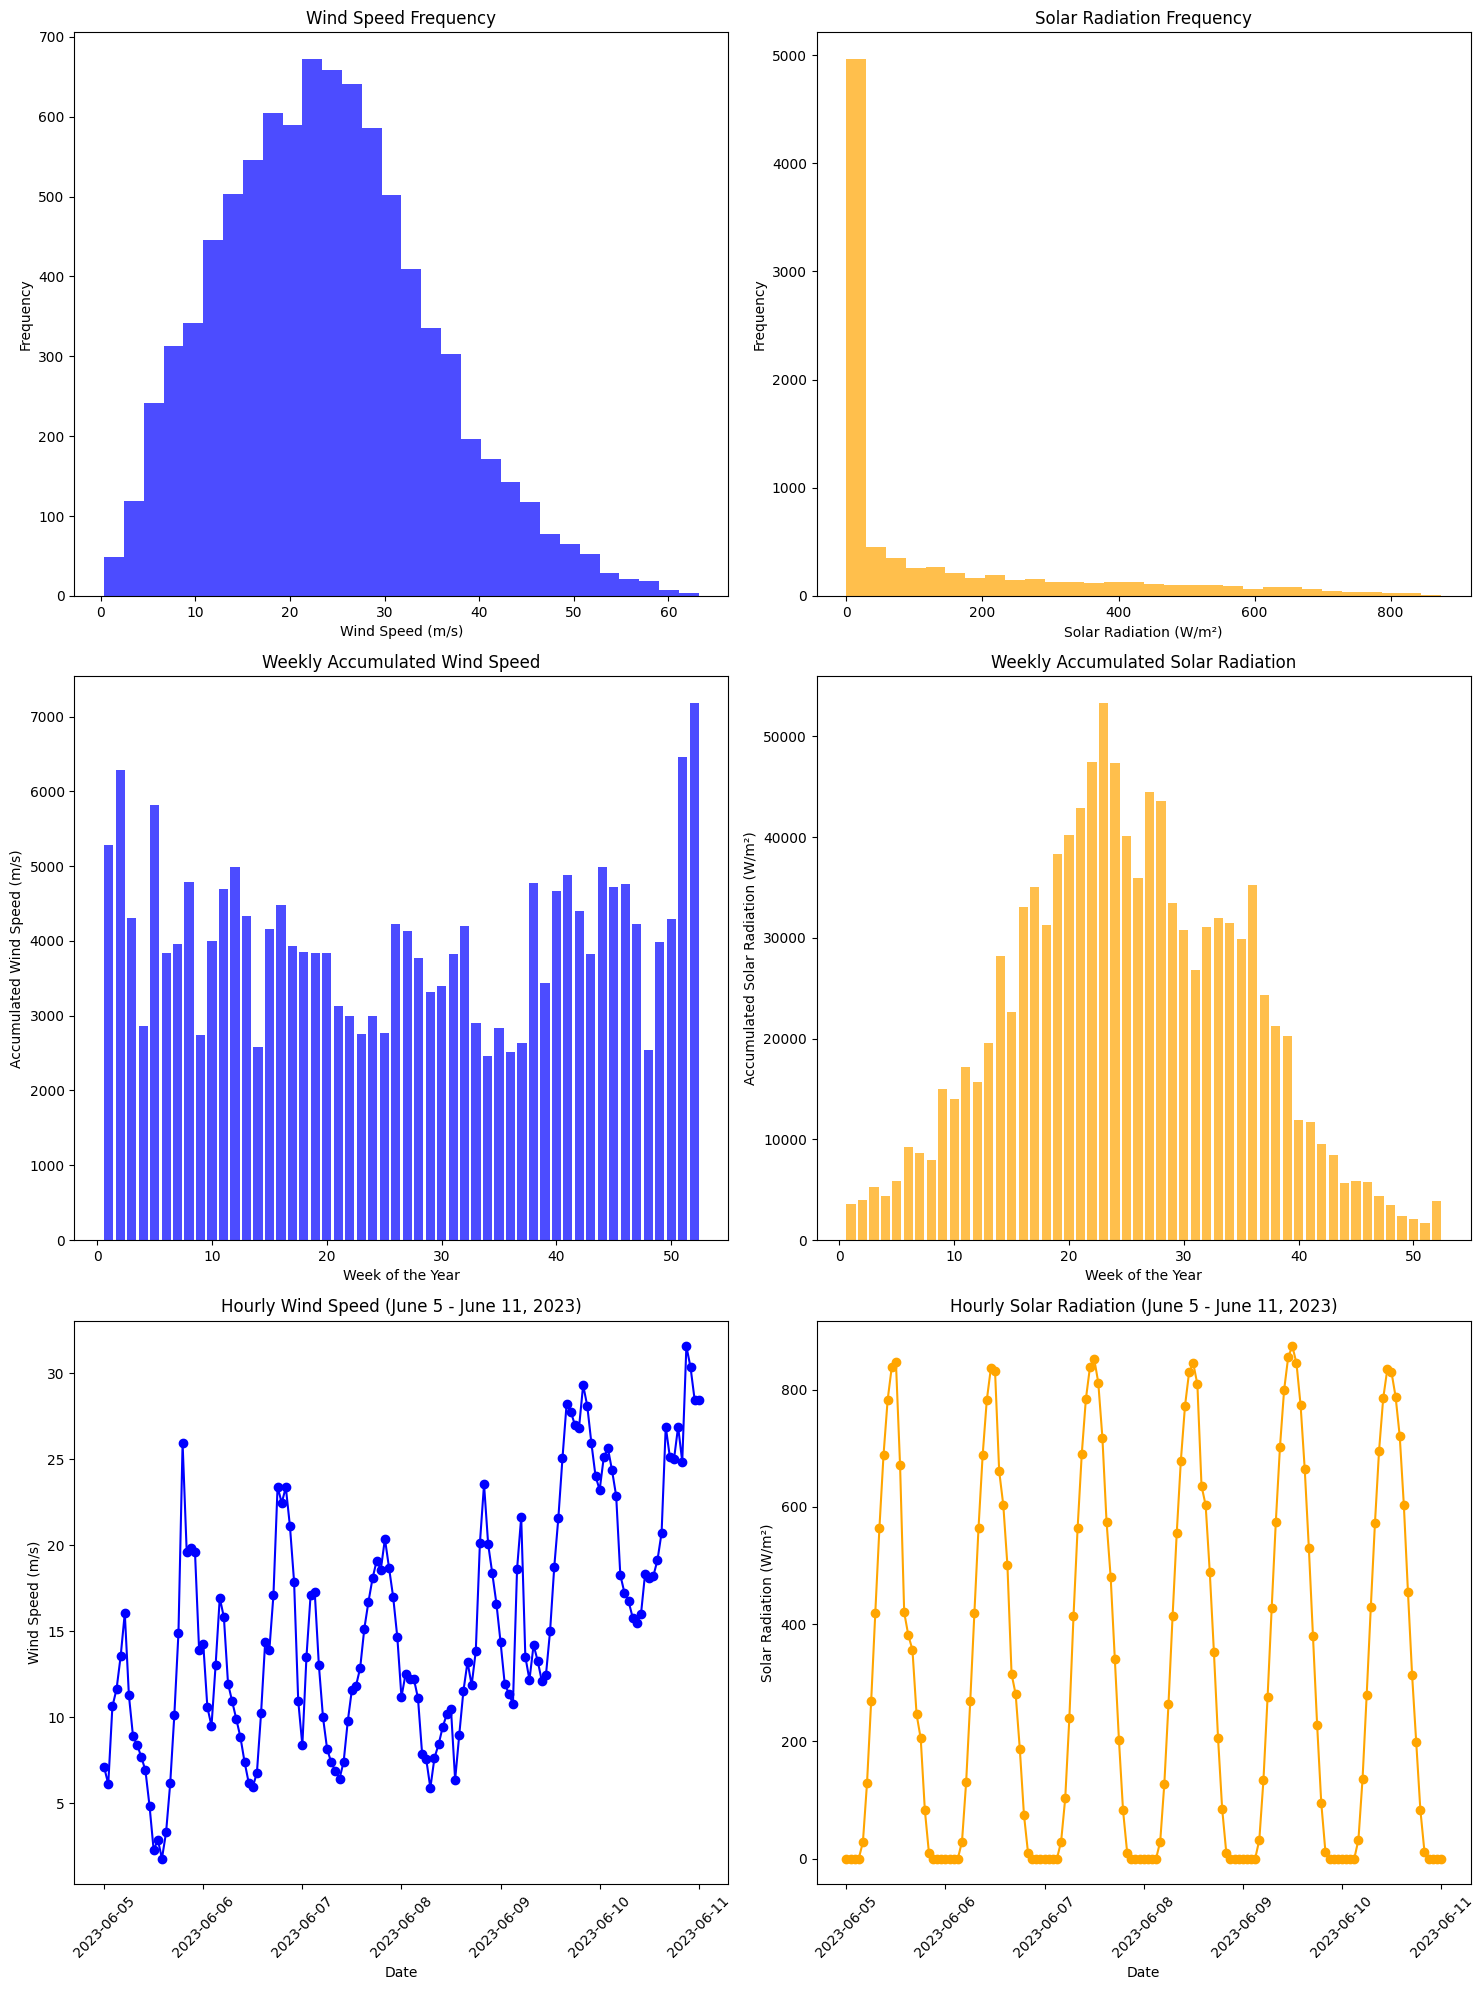

In [106]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 20))

axs[0, 0].hist(hourly_dataframe['wind_speed_100m'], bins=30, color='blue', alpha=0.7)
axs[0, 0].set_title('Wind Speed Frequency')
axs[0, 0].set_xlabel('Wind Speed (m/s)')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(hourly_dataframe['shortwave_radiation'], bins=30, color='orange', alpha=0.7)
axs[0, 1].set_title('Solar Radiation Frequency')
axs[0, 1].set_xlabel('Solar Radiation (W/m²)')
axs[0, 1].set_ylabel('Frequency')

hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])

weekly_wind = hourly_dataframe.groupby(hourly_dataframe['date'].dt.isocalendar().week)['wind_speed_100m'].sum()
weekly_solar = hourly_dataframe.groupby(hourly_dataframe['date'].dt.isocalendar().week)['shortwave_radiation'].sum()

axs[1, 0].bar(weekly_wind.index, weekly_wind, color='blue', alpha=0.7)
axs[1, 0].set_title('Weekly Accumulated Wind Speed')
axs[1, 0].set_xlabel('Week of the Year')
axs[1, 0].set_ylabel('Accumulated Wind Speed (m/s)')

axs[1, 1].bar(weekly_solar.index, weekly_solar, color='orange', alpha=0.7)
axs[1, 1].set_title('Weekly Accumulated Solar Radiation')
axs[1, 1].set_xlabel('Week of the Year')
axs[1, 1].set_ylabel('Accumulated Solar Radiation (W/m²)')

start_date = '2023-06-05'
end_date = '2023-06-11'

weekly_data = hourly_dataframe[(hourly_dataframe['date'] >= start_date) & (hourly_dataframe['date'] <= end_date)]

axs[2, 0].plot(weekly_data['date'], weekly_data['wind_speed_100m'], color='blue', marker='o', linestyle='-')
axs[2, 0].set_title('Hourly Wind Speed (June 5 - June 11, 2023)')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Wind Speed (m/s)')
axs[2, 0].tick_params(axis='x', rotation=45)

axs[2, 1].plot(weekly_data['date'], weekly_data['shortwave_radiation'], color='orange', marker='o', linestyle='-')
axs[2, 1].set_title('Hourly Solar Radiation (June 5 - June 11, 2023)')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Solar Radiation (W/m²)')
axs[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

At a later point, it would be the plan to elaborate on these weather patterns and what they mean for wind and solar power generation as well as power prices.

<a id="subsection-22"></a>
## Price Data Import

In [41]:
# The data stems from Ember

file_path = '/Users/ben/Downloads/european_wholesale_electricity_price_data_hourly/Germany.csv'

price_df = pd.read_csv(file_path)

price_df['Datetime (UTC)'] = pd.to_datetime(price_df['Datetime (UTC)'])

price_df = price_df[price_df['Datetime (UTC)'].dt.year == 2023]

price_df.reset_index(drop=True, inplace=True)

print(price_df.head())
print(price_df.tail())

   Country ISO3 Code      Datetime (UTC)     Datetime (Local)  \
0  Germany       DEU 2023-01-01 00:00:00  2023-01-01 01:00:00   
1  Germany       DEU 2023-01-01 01:00:00  2023-01-01 02:00:00   
2  Germany       DEU 2023-01-01 02:00:00  2023-01-01 03:00:00   
3  Germany       DEU 2023-01-01 03:00:00  2023-01-01 04:00:00   
4  Germany       DEU 2023-01-01 04:00:00  2023-01-01 05:00:00   

   Price (EUR/MWhe)  
0             -1.07  
1            -29.92  
2            -29.92  
3            -29.90  
4             -5.40  
      Country ISO3 Code      Datetime (UTC)     Datetime (Local)  \
8755  Germany       DEU 2023-12-31 19:00:00  2023-12-31 20:00:00   
8756  Germany       DEU 2023-12-31 20:00:00  2023-12-31 21:00:00   
8757  Germany       DEU 2023-12-31 21:00:00  2023-12-31 22:00:00   
8758  Germany       DEU 2023-12-31 22:00:00  2023-12-31 23:00:00   
8759  Germany       DEU 2023-12-31 23:00:00  2024-01-01 00:00:00   

      Price (EUR/MWhe)  
8755              7.95  
8756              

### Graphical Inspection

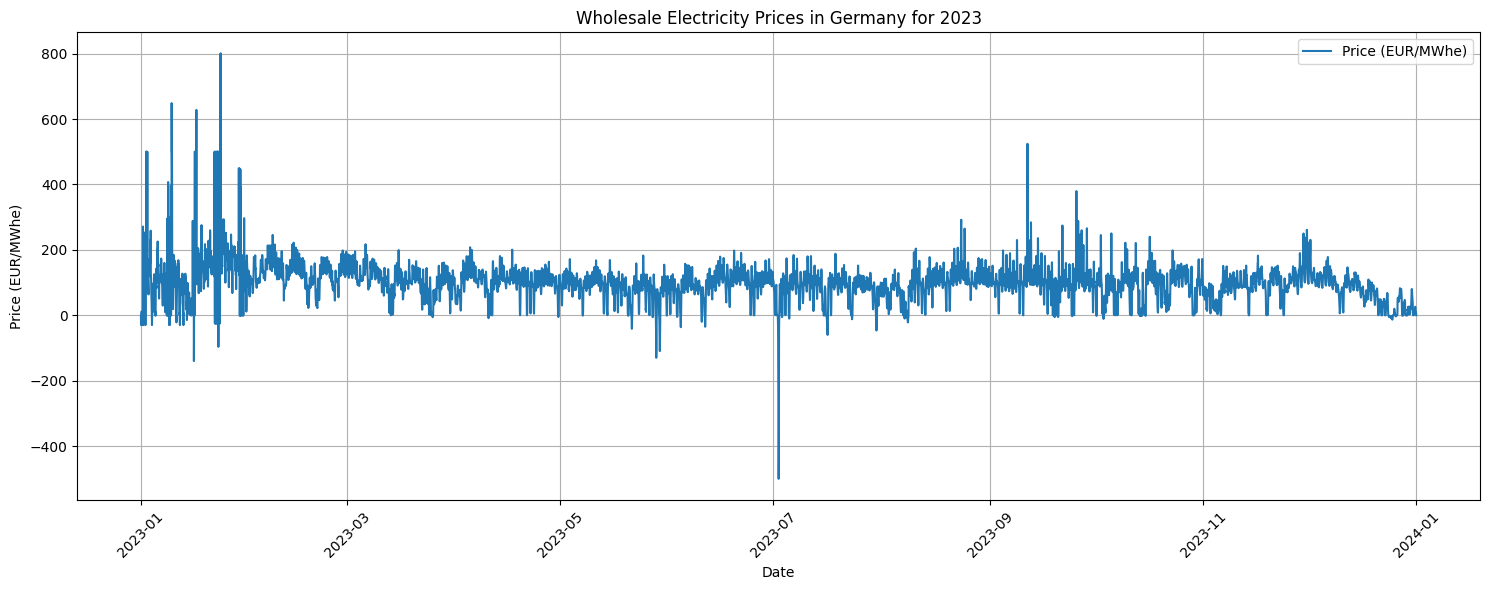

In [45]:
plt.figure(figsize=(15, 6))
plt.plot(price_df['Datetime (UTC)'], price_df['Price (EUR/MWhe)'], label='Price (EUR/MWhe)')
plt.title('Wholesale Electricity Prices in Germany for 2023')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

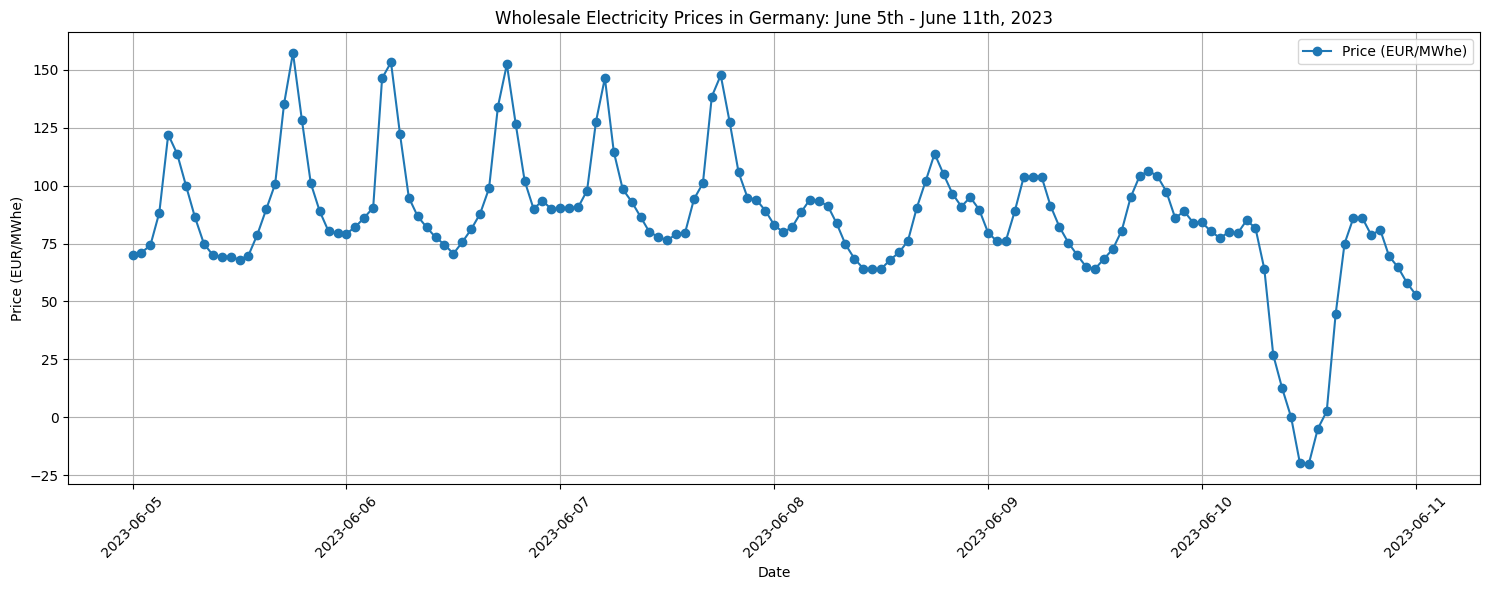

In [47]:
filtered_df = price_df[(price_df['Datetime (UTC)'] >= '2023-06-05') & (price_df['Datetime (UTC)'] <= '2023-06-11')]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(filtered_df['Datetime (UTC)'], filtered_df['Price (EUR/MWhe)'], label='Price (EUR/MWhe)', marker='o', linestyle='-')
plt.title('Wholesale Electricity Prices in Germany: June 5th - June 11th, 2023')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Again, an elaboration on the dynamics of the power market will follow later on.

<a id="section-3"></a>
# Combing the Datasets

<a id="subsection-31"></a>
## The Merge

In [62]:
price_df['Datetime (UTC)'] = price_df['Datetime (UTC)'].dt.tz_localize(None)
hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_localize(None)

merged_df = pd.merge(price_df, hourly_dataframe, left_on='Datetime (UTC)', right_on='date')

merged_df = merged_df.drop(columns=['date'])

print(merged_df.head())

   Country ISO3 Code      Datetime (UTC)     Datetime (Local)  \
0  Germany       DEU 2023-01-01 00:00:00  2023-01-01 01:00:00   
1  Germany       DEU 2023-01-01 01:00:00  2023-01-01 02:00:00   
2  Germany       DEU 2023-01-01 02:00:00  2023-01-01 03:00:00   
3  Germany       DEU 2023-01-01 03:00:00  2023-01-01 04:00:00   
4  Germany       DEU 2023-01-01 04:00:00  2023-01-01 05:00:00   

   Price (EUR/MWhe)  wind_speed_100m  shortwave_radiation  
0             -1.07        50.550205                  0.0  
1            -29.92        51.624554                  0.0  
2            -29.92        52.915100                  0.0  
3            -29.90        51.348927                  0.0  
4             -5.40        49.430241                  0.0  


<a id="subsection-32"></a>
## Additional Data Manipulation

In [63]:
merged_df['is_weekday'] = merged_df['Datetime (UTC)'].dt.dayofweek < 5

def get_period_of_day(hour):
    if 0 <= hour <= 6 or 22 < hour <= 24:
        return 'Night'
    elif 6 < hour <= 10:
        return 'Morning'
    elif 10 < hour <= 17:
        return 'Midday'
    else: # 17 < hour <= 22
        return 'Evening'
    
merged_df['period_of_day'] = merged_df['Datetime (UTC)'].dt.hour.apply(get_period_of_day)

period_dummies = pd.get_dummies(merged_df['period_of_day'])
del merged_df["period_of_day"]

merged_df = pd.concat([merged_df, period_dummies], axis=1)

print(merged_df.head())
print(merged_df.tail())

   Country ISO3 Code      Datetime (UTC)     Datetime (Local)  \
0  Germany       DEU 2023-01-01 00:00:00  2023-01-01 01:00:00   
1  Germany       DEU 2023-01-01 01:00:00  2023-01-01 02:00:00   
2  Germany       DEU 2023-01-01 02:00:00  2023-01-01 03:00:00   
3  Germany       DEU 2023-01-01 03:00:00  2023-01-01 04:00:00   
4  Germany       DEU 2023-01-01 04:00:00  2023-01-01 05:00:00   

   Price (EUR/MWhe)  wind_speed_100m  shortwave_radiation  is_weekday  \
0             -1.07        50.550205                  0.0       False   
1            -29.92        51.624554                  0.0       False   
2            -29.92        52.915100                  0.0       False   
3            -29.90        51.348927                  0.0       False   
4             -5.40        49.430241                  0.0       False   

   Evening  Midday  Morning  Night  
0    False   False    False   True  
1    False   False    False   True  
2    False   False    False   True  
3    False   False    

In [52]:
merged_df.to_csv('/Users/ben/Downloads/merged_df.csv', index=False)

<a id="section-4"></a>
# Regression analysis

With the given Data, I will now perform a regression analysis to gain insights on factors that explain the German hourly power prices.

<a id="subsection-41"></a>
## Mathematical Description of the Model 

The regression model developed aims to quantify the impact of wind speed, solar radiation, and the patterns associated with specific times of the day and whether the day is a weekday, on the electricity prices in Germany. We express the model as:

$$
P_t = \alpha + \beta_1 V_t + \beta_2 R_t + \beta_3 D_{\text{weekday}} + \beta_4 D_{\text{Evening}} + \beta_5 D_{\text{Midday}} + \beta_6 D_{\text{Morning}} + \beta_7 D_{\text{Night}} + \epsilon_t
$$

where:

- $P_t$: Power price in Germany at time $t$.
- $V_t$: Wind speed forecast at time $t$.
- $R_t$: Solar radiation forecast at time $t$.
- $D_{\text{weekday}}$: Dummy variable indicating if the time $t$ falls on a weekday (1) or not (0).
- $D_{\text{Evening}}, D_{\text{Midday}}, D_{\text{Morning}}, D_{\text{Night}}$: Dummy variables representing different periods of the day, where each period is assigned $1$ if time $t$ falls within that specific period and $0$ otherwise.
- $\alpha$: Intercept of the model, representing the baseline power price when all other variables are zero.
- $\beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6, \beta_7$: Coefficients indicating the influence of each variable on the power price. Specifically, $\beta_1$ and $\beta_2$ measure the impact of wind speed and solar radiation on the power price, respectively, while $\beta_3$ to $\beta_7$ measure the impacts of the day being a weekday and the respective time period of the day.
- $\epsilon_t$: Error term capturing all other factors affecting power prices at time $t$ not explicitly included in the model.

### Interpretation of Coefficients

- The **intercept** $\alpha$ provides an estimate of the average power price when the explanatory variables are at their reference levels (i.e., wind speed and solar radiation are zero, and it is neither a weekday nor within the specified periods of the day).
- The **coefficients** $\beta_1$ and $\beta_2$ represent the marginal impact of a one-unit increase in wind speed (in whatever units wind speed $V_t$ is measured) and solar radiation (in equivalent units for $R_t$), respectively, on the power price, holding all other factors constant.
- The **dummy variable coefficients** $\beta_3$ to $\beta_7$ indicate the differential impact on power prices due to time being in a specific period of the day or whether it's a weekday, relative to the baseline period not covered by these dummies (which, implicitly, is the reference category).

By estimating this model using Ordinary Least Squares (OLS) regression, we derive insights into how renewable energy availability (as captured by wind speed and solar radiation forecasts) and demand patterns (reflected by the time-of-day and weekday dummies) influence power prices in Germany. This analysis helps stakeholders understand the dynamics of energy markets better and make informed decisions regarding energy production, marketing, and policy-making.

<a id="subsection-42"></a>
## Execution of the Regression analysis

In [108]:
X = merged_df[['wind_speed_100m', 'shortwave_radiation', 'is_weekday', 'Evening', 'Midday', 'Morning', 'Night']]
X[['is_weekday', 'Evening', 'Midday', 'Morning', 'Night']] = X[['is_weekday', 'Evening', 'Midday', 'Morning', 'Night']].astype(int)
X = sm.add_constant(X)

y = merged_df['Price (EUR/MWhe)']

model = sm.OLS(y, X).fit()

coefficients = model.params
coefficients_df = pd.DataFrame(coefficients, columns=['Coefficient'])

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Price (EUR/MWhe)   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     697.3
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        23:55:13   Log-Likelihood:                -46083.
No. Observations:                8760   AIC:                         9.218e+04
Df Residuals:                    8753   BIC:                         9.223e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 116.9026    

/var/folders/m7/drz76g8d6z593bnk0jfrrxym0000gn/T/ipykernel_96098/3962232098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['is_weekday', 'Evening', 'Midday', 'Morning', 'Night']] = X[['is_weekday', 'Evening', 'Midday', 'Morning', 'Night']].astype(int)


In [67]:
print(coefficients_df)

                     Coefficient
const                 116.902636
wind_speed_100m        -2.226318
shortwave_radiation    -0.129688
is_weekday             30.563111
Evening                32.255567
Midday                 44.390966
Morning                34.040170
Night                   6.215934


These coefficients will be used in the model.

<a id="section-5"></a>
# The economic model

<a id="subsection-51"></a>
## Description of the model

### Optimization Model for Hydro Power Revenue Maximization with Predicted Power Prices

**Objective:** Maximize the hydro power company's revenue by optimally scheduling power generation over a week, taking into account water inflow dynamics, storage capacities, and forecasted power prices. The hydro power company is in another country than Germany but it's business is to export to Germany. The predicted power price, $\hat{P}_t$, is an integral part of the revenue model and is determined as follows for each hour $t$:

$$
\hat{P}_t = 116.902636 - 2.226318 \times \text{Wind Speed at 100m} - 0.129688 \times \text{Shortwave Radiation} + 30.563111 \times \text{Is Weekday} + 32.255567 \times \text{Evening} + 44.390966 \times \text{Midday} + 34.040170 \times \text{Morning} + 6.215934 \times \text{Night}
$$

#### Optimization Model Formulation:

**Decision Variables:**
- $X_t$: Quantity of power (MW) exported to Germany in hour $t$.
- $S_{t+1}$: Water storage level (cubic meters) at the end of hour $t$.

**Objective Function:**
Maximize total revenue from the exported power over a week:
\begin{equation}
\text{Maximize} \sum_{t=1}^{168} X_t \cdot \hat{P}_t
\end{equation}

**Subject to:**

1. **Power Generation Constraint:** Ensures that power generation is within the plant's capacity.
    $$
    0 \leq X_t \leq H_t, \quad \forall t
    $$

2. **Interconnection Capacity Constraint:** Limits the exported power to the maximum interconnection capacity.
    $$
    0 \leq X_t \leq C_{\text{max}}, \quad \forall t
    $$

3. **Water Storage Dynamics:** Describes the water balance, taking into account inflows and the water used for power generation.
    $$
    S_{t+1} = S_t + I_t - X_t, \quad 0 \leq S_{t+1} \leq W_{\text{max}}, \quad \forall t
    $$

4. **Mandatory Generation Trigger:** If the storage reaches its capacity, it triggers mandatory generation.
    $$
    \text{If } S_{t+1} = W_{\text{max}}, \text{ then } X_t = H_t
    $$

5. **Initial Storage Condition:** Specifies the initial storage level at the start of the week.
    $$
    S_1 = W_{\text{initial}}
    $$

Where:
- $H_t$: Maximum hydro power generation capacity (MW) at hour $t$.
- $C_{\text{max}}$: Maximum capacity of power (MW) that can be exported per hour.
- $I_t$: Constant inflow of water into the reservoir (cubic meters) per hour.
- $W_{\text{max}}$: Maximum capacity of the water storage (cubic meters).
- $W_{\text{initial}}$: Initial water storage level (cubic meters) at the start of optimization.
- $t = 1, \ldots, 168$: Indices representing each hour in a week.

This model is a simplified view of the complex decision-making process involved in hydroelectric power generation and sales. It captures the essence of operational constraints and market opportunities but may require modifications to address real-world complexities accurately.

<a id="subsection-52"></a>
## Solving the Model

In the following, the model will be solved using 

Firstly, I generate some synthetic data for the next week. Here, it would be nice to use actual predicitons of the next weeks weather.

In [83]:
import pandas as pd
import numpy as np

def get_period_of_day(hour):
    if 0 <= hour <= 6 or 22 < hour <= 23:
        return 'Night'
    elif 6 < hour <= 10:
        return 'Morning'
    elif 10 < hour <= 17:
        return 'Midday'
    else:  # 17 < hour <= 22
        return 'Evening'

start_date = pd.to_datetime('2024-05-13')

if start_date.dayofweek != 0:
    raise ValueError("Start date must be a Monday")

date_range = pd.date_range(start=start_date, periods=168, freq='H')

wind_speed_100m = np.random.normal(loc=30, scale=9, size=168)

shortwave_radiation = np.zeros(168) 

for i, dt in enumerate(date_range):
    if 7 <= dt.hour < 21:  # 7 AM to 9 PM
        shortwave_radiation[i] = np.random.normal(loc=200, scale=50)  

is_weekday = [(hr.weekday() < 5) * 1 for hr in date_range]
time_of_day = [get_period_of_day(hr.hour) for hr in date_range]

model_df = pd.DataFrame({
    'Timestamp': date_range,
    'Wind Speed (100m)': wind_speed_100m,
    'Shortwave Radiation': shortwave_radiation,
    'Is Weekday': is_weekday,
    'Time of Day': time_of_day
})

period_dummies = pd.get_dummies(model_df['Time of Day'])
del model_df["Time of Day"]

model_df = pd.concat([model_df, period_dummies], axis=1)

model_df.set_index('Timestamp', inplace=True)

/var/folders/m7/drz76g8d6z593bnk0jfrrxym0000gn/T/ipykernel_96098/1880590262.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=168, freq='H')


In [84]:
print(model_df.head())
print(model_df.tail())

                     Wind Speed (100m)  Shortwave Radiation  Is Weekday  \
Timestamp                                                                 
2024-05-13 00:00:00          37.206223                  0.0           1   
2024-05-13 01:00:00          41.472478                  0.0           1   
2024-05-13 02:00:00          11.157586                  0.0           1   
2024-05-13 03:00:00          28.826717                  0.0           1   
2024-05-13 04:00:00          22.300066                  0.0           1   

                     Evening  Midday  Morning  Night  
Timestamp                                             
2024-05-13 00:00:00    False   False    False   True  
2024-05-13 01:00:00    False   False    False   True  
2024-05-13 02:00:00    False   False    False   True  
2024-05-13 03:00:00    False   False    False   True  
2024-05-13 04:00:00    False   False    False   True  
                     Wind Speed (100m)  Shortwave Radiation  Is Weekday  \
Timestamp     

<a id="subsection-52"></a>
## Solving the Model

In [101]:
import pulp as lp


# Prediction part simplified for this example
coefficients = {
    'const': 116.902636,
    'wind_speed_100m': -2.226318,
    'shortwave_radiation': -0.129688,
    'is_weekday': 30.563111,
    'Evening': 32.255567,
    'Midday': 44.390966,
    'Morning': 34.040170,
    'Night': 6.215934
}

predicted_prices = coefficients['const'] + coefficients['wind_speed_100m'] * model_df['Wind Speed (100m)'] + coefficients['shortwave_radiation'] * model_df['Shortwave Radiation'] + coefficients['is_weekday'] * model_df['Is Weekday'] + coefficients['Evening'] * model_df['Evening'] + coefficients['Midday'] * model_df['Midday'] + coefficients['Morning'] * model_df['Morning'] + coefficients['Night'] * model_df['Night']

# Initialize the model
model = lp.LpProblem("Hydroelectric_Power_Plant_Optimization", lp.LpMaximize)

# Operational parameters
hours = len(predicted_prices)
generation_capacity = 100  # MW
water_inflow = 50  # cubic meters per hour
storage_capacity = 500  # cubic meters
initial_storage = 250  # cubic meters

# Decision variables
power_generated = lp.LpVariable.dicts("PowerGenerated", (i for i in range(hours)), lowBound=0, upBound=generation_capacity)
water_stored = lp.LpVariable.dicts("WaterStored", (i for i in range(hours+1)), lowBound=0, upBound=storage_capacity)

# Set initial storage
model += water_stored[0] == initial_storage

# Objective function - Maximize revenue from generated power
model += lp.lpSum([power_generated[i] * predicted_prices[i] for i in range(hours)])

# Constraints
for i in range(hours):
    # Water balance: water inflow + remaining water = water used for generation + water stored
    if i < hours - 1:
        model += water_inflow + water_stored[i] == power_generated[i] + water_stored[i+1]
    # Last hour: all water must be used or stored (no future)
    else:
        model += water_inflow + water_stored[i] == power_generated[i] + water_stored[i+1]

# Solve
model.solve()
print("Status:", lp.LpStatus[model.status])

generated_power_solution = [power_generated[i].varValue for i in range(hours)]
water_storage_solution = [water_stored[i].varValue for i in range(hours + 1)]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ben/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/m7/drz76g8d6z593bnk0jfrrxym0000gn/T/bcb176c7c4c9445393a6621c9cf523d5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/m7/drz76g8d6z593bnk0jfrrxym0000gn/T/bcb176c7c4c9445393a6621c9cf523d5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 174 COLUMNS
At line 848 RHS
At line 1018 BOUNDS
At line 1356 ENDATA
Problem MODEL has 169 rows, 337 columns and 505 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 163 (-6) rows, 330 (-7) columns and 492 (-13) elements
0  Obj -0 Primal inf 8599.9998 (162) Dual inf 13719.847 (168)
78  Obj 1371984.7 Primal inf 125450 (153)
154  Obj 886125.28 Primal inf 1550 (26)
177  Obj 849785.16
Optimal - objective value 849785.16
After Postsolve, objective 849785.16, 

/var/folders/m7/drz76g8d6z593bnk0jfrrxym0000gn/T/ipykernel_96098/4124438631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model += lp.lpSum([power_generated[i] * predicted_prices[i] for i in range(hours)])


<a id="subsection-53"></a>
## Graphical Inspection of the Model

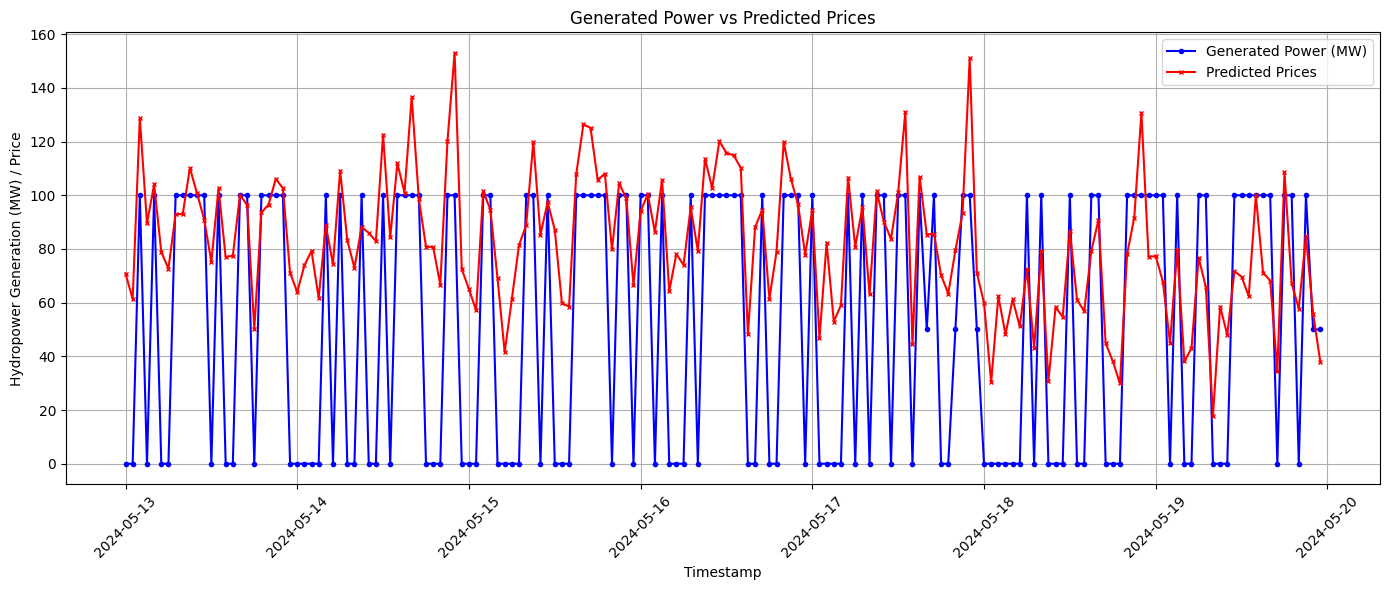

In [104]:
plt.figure(figsize=(14, 6))
plt.plot(model_df.index, generated_power_solution, label='Generated Power (MW)', color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(model_df.index, predicted_prices, label='Predicted Prices', color='red', marker='x', linestyle='-', markersize=3)
plt.title('Generated Power vs Predicted Prices')
plt.xlabel('Timestamp')
plt.ylabel('Hydropower Generation (MW) / Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

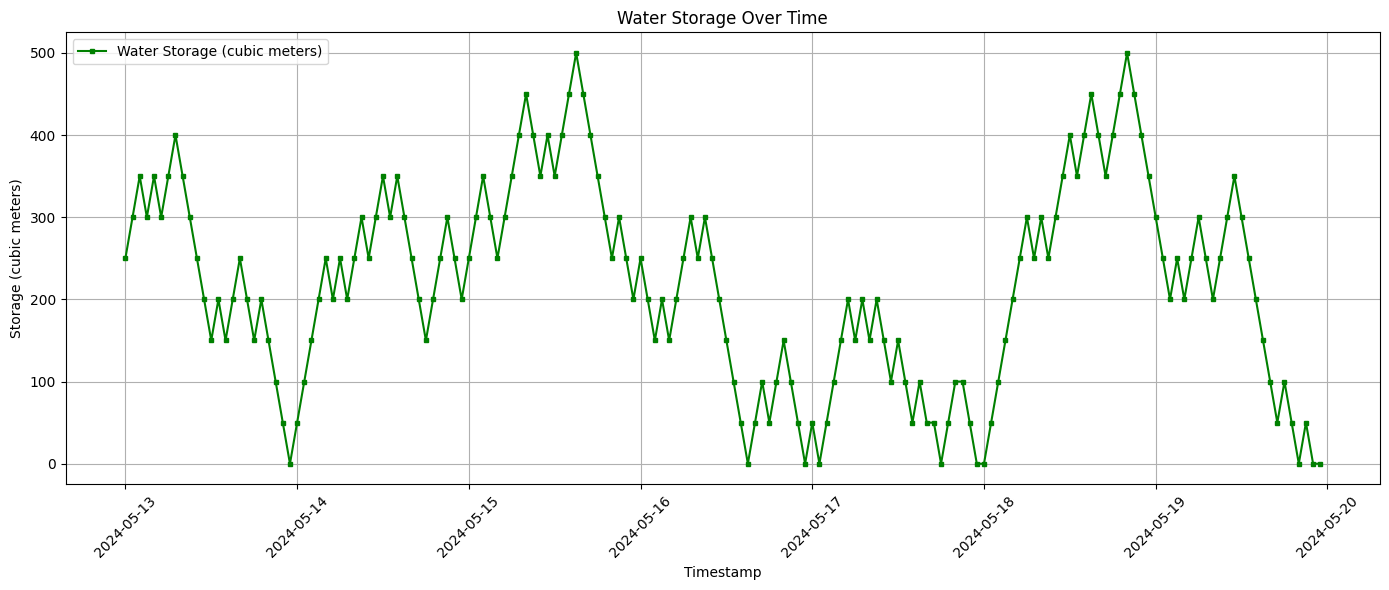

In [103]:
plt.figure(figsize=(14, 6))
plt.plot(model_df.index, water_storage_solution[:-1], label='Water Storage (cubic meters)', color='green', marker='s', linestyle='-', markersize=3)
plt.title('Water Storage Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Storage (cubic meters)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

An interpretation of the results will follow later but it can be seen that generation is successfully shifted to hours of higher expected prices.